In [1]:
import scipy.interpolate as interp
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import itertools
import pickle
import pandas as pd
import seaborn as sns
import anipose_scripts.anipose_main as main
import anipose_scripts.constants as constants
import tools
import pprint
import itertools
from analysis import *

plt.rcParams['figure.facecolor'] = 'white'

{'location': array([[   0,  323],
       [ 363, 1600]], dtype=int64), 'paw': array([[   0,  321],
       [ 367, 1600]], dtype=int64), 'pellet': array([[  0, 130]], dtype=int64)}


In [23]:
dict_of_data = {x: tools.get_files(main.pose2d_folder, (x + '.h5'))
                for x in constants.CAMERA_NAMES}
bps_to_include = np.unique([x for y in main.scheme for x in y])
bp_dict = {bp: i for i, bp in enumerate(bps_to_include)}

### LOOP OVER THIS
video_ix = 2

# DATA SHAPE [BODYPARTS, FRAMES, (X, Y, SCORE)]
data_dict = {}
region_dict = {}
for cam in constants.CAMERA_NAMES:
    data = load_to_np_array(dict_of_data[cam][video_ix], bps_to_include)
    # interpolate small missing regions per body part
    for bp_ix in range(data.shape[0]):
        x, y, score = repair_holes(x=data[bp_ix, :, 0],
                                       y=data[bp_ix, :, 1],
                                       score=data[bp_ix, :, 2],
                                       score_threshold=SCORE_THRESHOLD,
                                       default_interp_score_val=SCORE_INTERP,
                                       gap=NAN_GAP)
        data[bp_ix, :, 0] = x
        data[bp_ix, :, 1] = y
        data[bp_ix, :, 2] = score
    data_dict[cam]=data

    # chunk into good segments
    bps_regions_dict = {}
    for k, bps in BPS_CARE.items():
        bps_ix = [bp_dict[bp] for bp in bps]
        regions, region_ixs = get_good_chunks(data,
                                              bps_ix,
                                              score_threshold=SCORE_THRESHOLD,
                                              min_frames=CRITERIA_CONTIGUOUS_FRAMES)
        bps_regions_dict[k] = regions
    region_dict[cam]=bps_regions_dict

pprint.pprint(region_dict)



{'CAM0': {'location': array([[   0, 1265]], dtype=int64),
          'paw': array([[   0,  620],
       [ 624, 1167]], dtype=int64),
          'pellet': array([[   0,  211],
       [ 302,  312],
       [ 489,  507],
       [ 514,  582],
       [ 590,  602],
       [ 619,  634],
       [ 697,  768],
       [ 772,  786],
       [ 943,  955],
       [ 988, 1053]], dtype=int64)},
 'CAM1': {'location': array([[  0, 226],
       [230, 307],
       [320, 359],
       [411, 420],
       [434, 446],
       [481, 491],
       [611, 620],
       [632, 641],
       [654, 664],
       [816, 825],
       [892, 904],
       [981, 992]], dtype=int64),
          'paw': array([[ 13,  30],
       [ 45,  83],
       [133, 148],
       [243, 307],
       [325, 335],
       [345, 359],
       [436, 445],
       [482, 491],
       [611, 619],
       [633, 641],
       [654, 664],
       [816, 825],
       [893, 904],
       [981, 992]], dtype=int64),
          'pellet': array([[  0, 231],
       [242, 312],
 

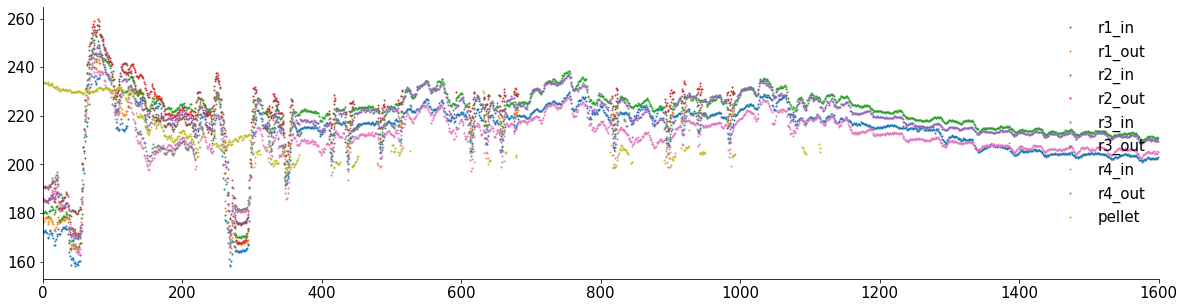

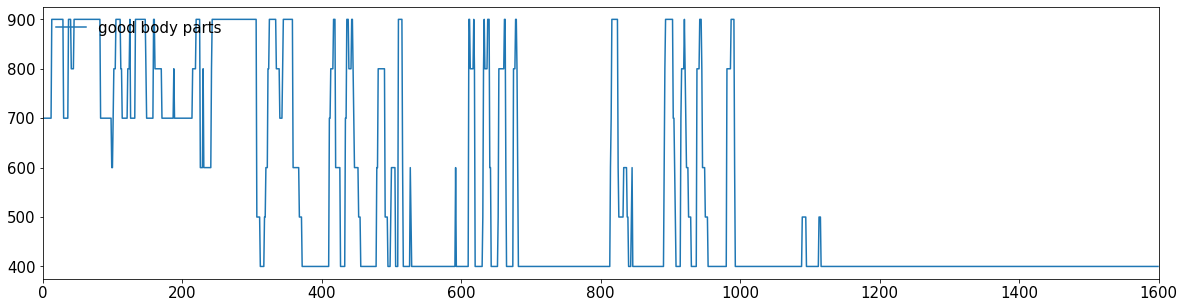

In [24]:
bp_ixs = [bp_dict[bp] for bp in BPS_TRACK_PAW + BPS_TRACK_PELLET]
x = data[bp_ixs, :, 0]
y = data[bp_ixs, :, 1]
score = data_dict['CAM1'][bp_ixs, :, 2]
pass_threshold = score > SCORE_THRESHOLD
num_good_bps = np.sum(pass_threshold, axis=0)

x_ = np.ma.masked_where(score < SCORE_THRESHOLD, x)
y_ = np.ma.masked_where(score < SCORE_THRESHOLD, y)

plt.figure(figsize=(20, 5))
plt.plot(x_.T, '.', markersize=2)
plt.xlim([0, data.shape[1]])
plt.legend(BPS_TRACK_PAW + BPS_TRACK_PELLET, frameon=False, loc='upper right')
sns.despine()
plt.figure(figsize=(20, 5))
plt.plot(num_good_bps*100)
plt.xlim([0, data.shape[1]])
plt.legend(['good body parts'], frameon=False, loc='upper left')

In [25]:

FILTER_WINDOW_MS = 125
FILTER_WINDOW_FRAMES = FILTER_WINDOW_MS * FRAME_RATE // 1000

def compute_angles(a, b, c, degrees=True):
    '''Computes angles between 3 point arrays of shape [points, coordinates]'''
    ba = b - a
    bc = b - c
    dp = np.diagonal(np.dot(ba, bc.T))
    cosine_angle = dp / (np.linalg.norm(ba, axis=1) * np.linalg.norm(bc, axis=1))
    angle = np.arccos(cosine_angle)
    if degrees:
        angle = np.degrees(angle)
    return angle

def interpolate_polyline(polyline, num_points):
    # tck, u = interp.splprep(polyline.T, s=INTERP_SMOOTH_MOTION_COEFFICIENT)
    tck, u = interp.splprep(polyline.T, s=3)
    u = np.linspace(0.0, 1.0, num_points)
    return interp.splev(u, tck)

### LOOP OVER THIS
from collections import defaultdict
dd = defaultdict(list)

for cam in constants.CAMERA_NAMES:
    for k, regions in region_dict[cam].items():
        for region_ix, region in enumerate(regions):
            bps = BPS_CARE[k]
            bps_ix = [bp_dict[bp] for bp in bps]
            x = data_dict[cam][bps_ix, region[0]:region[1], 0]
            y = data_dict[cam][bps_ix, region[0]:region[1], 1]

            x_av = np.mean(x, axis=0)
            y_av = np.mean(y, axis=0)
            x_itp, y_itp = interpolate_polyline(np.array([x_av, y_av]).T, len(x_av))
            x_velocity = np.diff(x_itp)
            x_velocity = np.hstack((x_velocity[0], x_velocity))
            y_velocity = np.diff(y_itp)
            y_velocity = np.hstack((y_velocity[0], y_velocity))

            angles = []
            for paw_bps in BPS_ANGLES[k]:
                angle_ixs = [bp_dict[bp] for bp in paw_bps]
                angle_coors = data_dict[cam][angle_ixs, region[0]:region[1],
                              :2]
                angles.append(compute_angles(angle_coors[0],
                                             angle_coors[1],
                                             angle_coors[2]))
            if len(angles):
                angles = np.mean(angles, axis=0)
                angles_smoothed=savgol_filter(angles,
                                              window_length=FILTER_WINDOW_FRAMES,
                                              polyorder=0)
                angles_v = np.diff(angles_smoothed)
                angles_v = np.hstack((angles_v[0], angles_v))
                angles_v=savgol_filter(angles_v,
                                              window_length=FILTER_WINDOW_FRAMES,
                                              polyorder=0)

                angles_a = np.diff(angles_v)
                angles_a = np.hstack((angles_a[0], angles_a))
                # angles_v=savgol_filter(angles_v,
                #                               window_length=FILTER_WINDOW_FRAMES,
                #                               polyorder=0)
            else:
                angles = []
                angles_smoothed=[]
                angles_v = []
                angles_a = []


            dd['camera'].append(cam)
            dd['experiment'].append(k)
            dd['bps'].append(bps)
            dd['region_ix'].append(region_ix)
            dd['region'].append(region)
            dd['xp'].append(x_av)
            dd['yp'].append(y_av)
            dd['xitp'].append(x_itp)
            dd['yitp'].append(y_itp)
            dd['xv'].append(x_velocity)
            dd['yv'].append(y_velocity)
            dd['ap'].append(angles)
            dd['aitp'].append(angles_smoothed)
            dd['av'].append(angles_v)
            dd['aa'].append(angles_a)

df = pd.DataFrame(dd)
df.head()

,camera,experiment,bps,region_ix,region,xp,yp,xitp,yitp,xv,yv,ap,aitp,av,aa
0,CAM0,location,"[r2_in, r2_out, r3_in, r3_out]",0,"[0, 1265]","[209.84418869018555, 209.73161697387695, 209.3...","[95.64187431335449, 95.43959617614746, 95.5128...","[209.84327687835682, 208.94781801344536, 208.3...","[95.64159900041486, 95.11431486774771, 95.2926...","[-0.8954588649114612, -0.8954588649114612, -0....","[-0.5272841326671482, -0.5272841326671482, 0.1...","[98.11675021296767, 97.4786307121255, 96.66302...","[97.35316959947664, 97.35316959947664, 97.3531...","[-0.14471643131129214, -0.14471643131129214, -...","[0.0, 0.0, 2.7755575615628914e-17, 0.034237601..."
1,CAM0,paw,"[r1_in, r1_out, r2_in, r2_out, r3_in, r3_out, ...",0,"[0, 620]","[212.09919929504395, 211.97849082946777, 211.5...","[91.56591892242432, 91.45252990722656, 91.4221...","[212.1126805953701, 210.8207300383446, 209.777...","[91.52653812244864, 91.10720773665601, 91.8258...","[-1.2919505570255012, -1.2919505570255012, -1....","[-0.4193303857926338, -0.4193303857926338, 0.7...","[104.77633884525687, 104.86781640326505, 104.0...","[103.8702345460628, 103.8702345460628, 103.870...","[-0.290936837659379, -0.290936837659379, -0.29...","[0.0, 0.0, 5.551115123125783e-17, -0.127731509..."
2,CAM0,paw,"[r1_in, r1_out, r2_in, r2_out, r3_in, r3_out, ...",1,"[624, 1167]","[213.32714080810547, 213.18854904174805, 212.9...","[75.3057804107666, 74.7916669845581, 74.637960...","[213.3406605097244, 212.92439858181393, 212.10...","[75.31032984194471, 74.664535240386, 74.831654...","[-0.4162619279104547, -0.4162619279104547, -0....","[-0.6457946015587055, -0.6457946015587055, 0.1...","[87.50863801715123, 87.8617453163945, 88.71791...","[87.78495511102848, 87.78495511102848, 87.7849...","[0.0830339309346698, 0.0830339309346698, 0.083...","[0.0, 0.0, -1.3877787807814457e-17, 0.03481202..."
3,CAM0,pellet,[pellet],0,"[0, 211]","[242.14044189453125, 241.85671997070312, 240.9...","[107.8974838256836, 107.79993438720703, 107.86...","[242.1477573410566, 241.3645404849796, 240.735...","[107.87344371447145, 107.74202858149572, 107.7...","[-0.7832168560769901, -0.7832168560769901, -0....","[-0.13141513297573226, -0.13141513297573226, 0...",[],[],[],[]
4,CAM0,pellet,[pellet],1,"[302, 312]","[210.17755126953125, 211.76324462890625, 213.3...","[76.88478088378906, 76.29613494873047, 75.7074...","[210.19957190338076, 211.18319094841115, 212.2...","[76.84443813670117, 76.58701791036246, 76.2065...","[0.9836190450303945, 0.9836190450303945, 1.027...","[-0.2574202263387093, -0.2574202263387093, -0....",[],[],[],[]


Text(0, 0.5, 'Velocity (pixels / frames)')

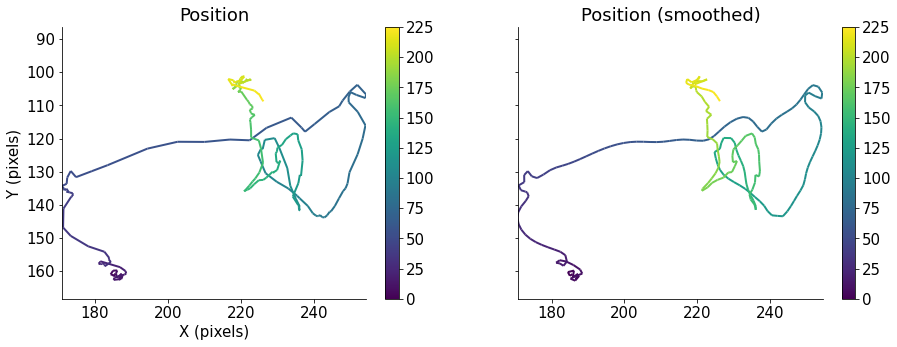

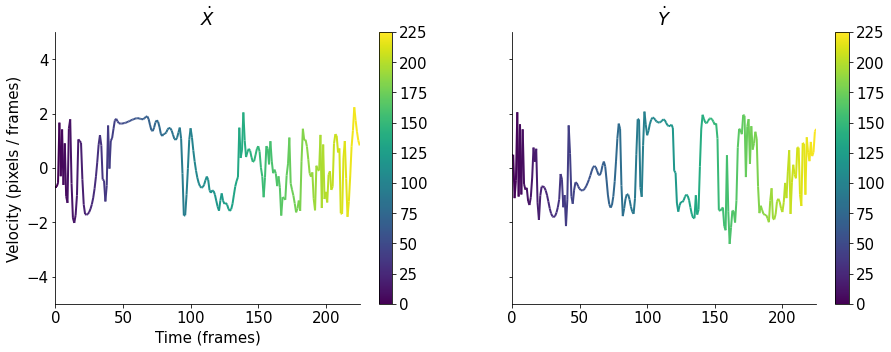

In [26]:
def make_multicolored_line(x, y, plot_args):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    c = np.arange(len(points))
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(c.min(), c.max())
    lc = LineCollection(segments, norm=norm, **plot_args)
    lc.set_array(c)
    lc.set_linewidth(2)
    return lc

def make_plot(x, y, plot_args, title, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    lc = make_multicolored_line(x, y, plot_args)
    line = ax.add_collection(lc)
    plt.colorbar(line, ax=ax)
    ax.set_title(title)
    sns.despine()

vec = df.query("camera=='CAM1' & experiment=='location' & region_ix==0")
region = vec['region'].iloc[0]
x_av = vec['xp'].iloc[0]
y_av = vec['yp'].iloc[0]
x_itp = vec['xitp'].iloc[0]
y_itp = vec['yitp'].iloc[0]
x_v = vec['xv'].iloc[0]
y_v = vec['yv'].iloc[0]

plot_args = {'cmap': 'viridis'}
f, axs = plt.subplots(nrows=1,
                      ncols=2,
                      figsize=(15, 5),
                      sharex=True,
                      sharey=True
                      )

make_plot(x_av, y_av, plot_args, 'Position', ax=axs[0])
make_plot(x_itp, y_itp, plot_args, 'Position (smoothed)', ax=axs[1])
bound = (x_av.max() - x_av.min())//2
axs[0].set_xlim(x_av.min(), x_av.max())
axs[0].set_ylim(y_av.mean() - bound, y_av.mean() + bound)
axs[0].invert_yaxis()
axs[0].set_xlabel('X (pixels)')
axs[0].set_ylabel('Y (pixels)')

f, axs = plt.subplots(nrows=1,
                      ncols=2,
                      figsize=(15, 5),
                      sharex=True,
                      sharey=True
                      )

make_plot(np.arange(region[0], region[1]),
          x_v,
          plot_args,
          r"$\.X$",
          axs[0])

make_plot(np.arange(region[0], region[1]),
          y_v,
          plot_args,
          r"$\.Y$",
          axs[1])
axs[0].set_ylim(-5, 5)
axs[0].set_xlabel('Time (frames)')
axs[0].set_ylabel('Velocity (pixels / frames)')

In [27]:
THRESHOLD_PIXELS_PER_SECOND = 40
THRESHOLD_PIXELS_PER_FRAME = THRESHOLD_PIXELS_PER_SECOND / FRAME_RATE
THRESHOLD_DURATION_MS = 250
THRESHOLD_DURATION_FRAMES = THRESHOLD_DURATION_MS * FRAME_RATE // 1000

# GET REACHS
vec = df.query("camera=='CAM1' & experiment=='location'")
all_forward_reaches = []
maximal_extensions = []
for i in range(len(vec)):
    region = vec['region'].iloc[i]
    x_p = vec['xp'].iloc[i]
    x_v = vec['xv'].iloc[i]
    y_v = vec['yv'].iloc[i]
    a_p = vec['ap'].iloc[i]

    reach_regions, _ = find_region_bounds(
        bool_array=x_v > THRESHOLD_PIXELS_PER_FRAME,
        min_gap=THRESHOLD_DURATION_FRAMES)
    retract_regions, _ = find_region_bounds(
        bool_array=x_v < -THRESHOLD_PIXELS_PER_FRAME,
        min_gap=THRESHOLD_DURATION_FRAMES
    )
    all_forward_reaches.append(reach_regions + region[0])
    for r in reach_regions:
        ix = region[0] + r[0] + np.argmax(x_p[r[0]:r[1]+20])
        maximal_extensions.append(ix)

all_forward_reaches = np.array([x for y in all_forward_reaches for x in y])


# # GET GRABS
# vec = df.query("camera=='CAM0' & experiment=='paw'")
# all_grabs = []
#
# for i in range(len(vec)):
#     region = vec['region'].iloc[i]
#     a_p = vec['ap'].iloc[i]
#     a_v = vec['av'].iloc[i]
#     grabs, _ = find_region_bounds(
#         bool_array=a_v > 1,
#         min_gap=4, max_gap=20)
#     grabs = grabs + region[0]
#     all_grabs.append(grabs)
#
#     for r in grabs:
#         print(a_p[r[0]:r[1]+5])
#         ix = r[0] + np.argmax(a_p[r[0]:r[1]+5])
#         maximal_extensions.append(ix)
# all_grabs = np.array([x for y in all_grabs for x in y])
# print(f'grabs: {all_grabs}')
#
print(f'forward reaches: {all_forward_reaches}')
print(f'maximal_extensions: {maximal_extensions}')

forward reaches: [[ 42  94]
 [285 307]
 [348 359]]
maximal_extensions: [72, 305, 358]


(0.0, 500.0)

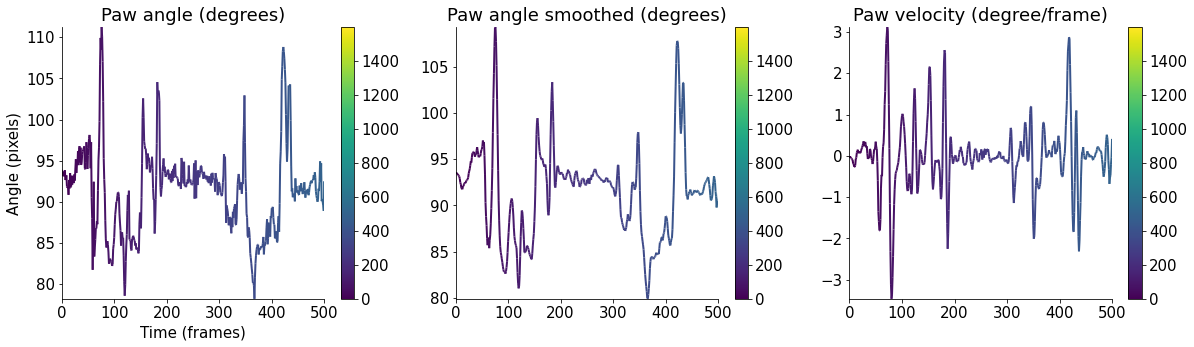

In [11]:
vec = df.query("camera=='CAM0' & experiment=='location' & region_ix==0")
vec.head()
region = vec['region'].iloc[0]
a_p = vec['ap'].iloc[0]
a_itp = vec['aitp'].iloc[0]
a_v = vec['av'].iloc[0]
a_a = vec['aa'].iloc[0]

f, axs = plt.subplots(nrows=1,
                      ncols=3,
                      figsize=(20, 5),
                      )

make_plot(np.arange(region[0], region[1]),
          a_p,
          plot_args,
          r"Paw angle (degrees)",
          axs[0])

make_plot(np.arange(region[0], region[1]),
          a_itp,
          plot_args,
          r"Paw angle smoothed (degrees)",
          axs[1])

make_plot(np.arange(region[0], region[1]),
          a_v,
          plot_args,
          r"Paw velocity (degree/frame)",
          axs[2])

axs[0].set_xlabel('Time (frames)')
axs[0].set_ylabel('Angle (pixels)')

xlim = [0, 500]
axs[0].set_xlim(xlim)
axs[1].set_xlim(xlim)
axs[2].set_xlim(xlim)

In [10]:
len(a_v)


1600

In [ ]:
points = np.array([x_av, y_av]).T
plot_points = []
for ix in range(points.shape[0]-trailing):
    plot_points.append(points[ix:ix+trailing])

from matplotlib import animation
f = plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.set_xlim(x_av.min(), x_av.max())
ax.set_ylim(y_av.min(), y_av.max())
ax.invert_yaxis()
color = np.arange(len(plot_points))
line, = plt.plot(plot_points[0][:, 0], plot_points[0][:, 1])


def animate(i):
    line.set_data(plot_points[i][:, 0], plot_points[i][:, 1])
    return line,

anim = animation.FuncAnimation(f,
                               animate,
                               frames=len(plot_points),
                               blit=True)
anim.save('basic_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
plt.show()